# Homework 1: Finding Similar Items: Textually Similar Documents

Group 28: Fabio Camerota, Gianluca Ruberto

## Solution


###Framework

The goal of this homework was to find textually similar documents based on Jaccard similarity using the shingling, minhashing, and locality-sensitive hashing (LSH) techniques. <br>
The language of choice was Python and the big data processing framework used was Spark, due to the scalability provided.

### Dataset


The dataset was downloaded from https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

###How to run the notebook

The notebook is ready to run on Google Colab. It can be also downloaded an run locally. In the latter case it is necessary to install all the libraries (pyspark, findspark, matplotlib)

###Default values

Since we are dealing with newspaper articles, we are using shingles of default size 5. The default length of minHash signatures is 100. The default number of bands is 10 and the default threshold is 0.8.

## Preliminary Steps

###Libraries

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Data_Mining

Mounted at /gdrive
/gdrive/MyDrive/Data_Mining


In [2]:
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 46 kB/s 
     |████████████████████████████████| 199 kB 46.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845514 sha256=a95a314ca131aeb45e2125f1e85a9b3917d5c6b1b653a44f6508e7a1f31fc6c0
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pyspark
import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,isnan, when, count,col, monotonically_increasing_id, split,length,stddev,avg,transform,size,array_intersect,array_union,collect_set
from pyspark.sql.types import IntegerType, ArrayType, StringType, LongType, DecimalType, FloatType, MapType, StructType, StructField
import sys
import time
import random
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
byteseed = seed.to_bytes(2, 'big')

### Spark setup

In [4]:
findspark.init()
findspark.find()
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

### Load data

In [5]:
df = spark.read.csv("News/True.csv",header = True).limit(500)
df

title,text,subject,date
As U.S. budget fi...,WASHINGTON (Reute...,politicsNews,"December 31, 2017"
U.S. military to ...,WASHINGTON (Reute...,politicsNews,"December 29, 2017"
Senior U.S. Repub...,WASHINGTON (Reute...,politicsNews,"December 31, 2017"
FBI Russia probe ...,WASHINGTON (Reute...,politicsNews,"December 30, 2017"
Trump wants Posta...,SEATTLE/WASHINGTO...,politicsNews,"December 29, 2017"
"White House, Cong...","WEST PALM BEACH, ...",politicsNews,"December 29, 2017"
Trump says Russia...,"WEST PALM BEACH, ...",politicsNews,"December 29, 2017"
Factbox: Trump on...,The following sta...,politicsNews,"December 29, 2017"
Trump on Twitter ...,The following sta...,politicsNews,"December 29, 2017"
Alabama official ...,WASHINGTON (Reute...,politicsNews,"December 28, 2017"


### Data preprocessing

In [6]:
df = df.withColumn("id", monotonically_increasing_id())
df = df.withColumnRenamed("text","Text")
df

title,Text,subject,date,id
As U.S. budget fi...,WASHINGTON (Reute...,politicsNews,"December 31, 2017",0
U.S. military to ...,WASHINGTON (Reute...,politicsNews,"December 29, 2017",1
Senior U.S. Repub...,WASHINGTON (Reute...,politicsNews,"December 31, 2017",2
FBI Russia probe ...,WASHINGTON (Reute...,politicsNews,"December 30, 2017",3
Trump wants Posta...,SEATTLE/WASHINGTO...,politicsNews,"December 29, 2017",4
"White House, Cong...","WEST PALM BEACH, ...",politicsNews,"December 29, 2017",5
Trump says Russia...,"WEST PALM BEACH, ...",politicsNews,"December 29, 2017",6
Factbox: Trump on...,The following sta...,politicsNews,"December 29, 2017",7
Trump on Twitter ...,The following sta...,politicsNews,"December 29, 2017",8
Alabama official ...,WASHINGTON (Reute...,politicsNews,"December 28, 2017",9


In [7]:
# couting rows
df.count()

500

In [8]:
# checking for null values
null_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_values.show()

+-----+----+-------+----+---+
|title|Text|subject|date| id|
+-----+----+-------+----+---+
|    0|   0|      0|   0|  0|
+-----+----+-------+----+---+



In [9]:
# checking for None values
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+-----+----+-------+----+---+
|title|Text|subject|date| id|
+-----+----+-------+----+---+
|    0|   0|      0|   0|  0|
+-----+----+-------+----+---+



In [10]:
df.printSchema()

root
 |-- title: string (nullable = true)
 |-- Text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- id: long (nullable = false)



In [11]:
df.collect()[0]

Row(title='As U.S. budget fight looms, Republicans flip their fiscal script', Text='WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional

In [12]:
lengthDF = df.select(col("id"),col("Text"), length(col("Text")).alias("Length") )
lengthDF

id,Text,Length
0,WASHINGTON (Reute...,4659
1,WASHINGTON (Reute...,4077
2,WASHINGTON (Reute...,2789
3,WASHINGTON (Reute...,2461
4,SEATTLE/WASHINGTO...,5204
5,"WEST PALM BEACH, ...",3707
6,"WEST PALM BEACH, ...",3220
7,The following sta...,856
8,The following sta...,632
9,WASHINGTON (Reute...,408


In [13]:
lengthDF.select(avg("Length"),stddev("Length"))

avg(Length),stddev_samp(Length)
2388.97,1696.2789775976355


##Defining Functions

###Shingling

#### Construct k–shingles

In [14]:
def shingle_document(text,k):
    length = len(text)
    shingles = set()
    i = 0
    while i <= length - k:
        shingles.add(text[i:i+k])
        i+=1
    return list(shingles)

#### Compute shingling in a distributed way using Spark

In [15]:
def shingling(df,k):
    shingle_documentUDF = udf(lambda x: shingle_document(x,k), ArrayType(StringType(),False))
    shingledDF = df.select(col("id"),col("Text"), shingle_documentUDF(col("Text")).alias("Shinlings") )
    hashedDF = shingledDF.select(col("id"),col("Text"),col("Shinlings"), transform(col("Shinlings"), lambda x : pyspark.sql.functions.hash(x)).alias("Hashed") )
    return hashedDF

###Jaccard Similarity

Compute the jaccard similarity of two sets of hashed shingles by using the spark built-in union and intersection operations.

The join is made between the hashed k–shingles Dataframe and its copy.
The condition "<" is needed to eliminate rows with the same id pair.

In [16]:
def compareSets(hashedDF):
    hashedDF_copied = hashedDF.withColumn("HashedCopy",col("Hashed"))
    hashedDF_copied = hashedDF_copied.withColumn("idCopy",col("id"))
    a = hashedDF_copied.select(col("id"),col("Hashed"))
    b = hashedDF_copied.select(col("idCopy"),col("HashedCopy"))
    joinedDF = a.join(b, a.id < b.idCopy)
    jaccardDF = joinedDF.select(col("id"),col("idCopy"), (size(array_intersect(col("Hashed"),col("HashedCopy")))/size(array_union(col("Hashed"),col("HashedCopy")))).alias("Jaccard"))
    jaccardDF = jaccardDF.sort(col("Jaccard").desc())
    return jaccardDF

### MinHashing

####Create the minHash signature

This function builds a minHash signature of a document  (in the form of a vector or a set) of a given length n from a given set of integers (a set of hashed shingles).<br>


In [17]:
def minHashing_document(hashed,a,b,n):
    minHashed = []
    for i,j in zip(a,b):
        minimum = (hashed[0]*(i+1) + j+1) % n
        index = 0
        z = 1
        lenght = len(hashed)
        while z < lenght:
            hashElem = (hashed[z]*(i+1) + j+1) % n
            if hashElem < minimum:
                minimum = hashElem
                index = z
            z+=1
        minHashed.append(hashed[index])
    return minHashed

####Apply MinHashing in a distributed way using Spark

In order to generate N independent hash functions with the form h(x)= (ax + b) % c random numbers are generated.

In [18]:
def minHashing(hashedShingledDf,n):
    a = []
    b = []
    for t in range(n):
        a.append(random.randint(-n,n))
        b.append(random.randint(-n,n))
    minHashing_documentUDF = udf(lambda x: minHashing_document(x,a,b,n),ArrayType(IntegerType(),False)) 
    minHashedDF = hashedShingledDf.select(col("id"), minHashing_documentUDF(col("Hashed")).alias("minHashed") )
    return minHashedDF

#### Estimate the similarity of two integer vectors (minhash signatures) as a fraction of components in which they agree

In [19]:
def compareSignatures_documents(list1,list2):
    count = 0
    length = len(set(list1))
    for i in range(length):
        if list1[i] == list2[i]:
            count+=1
    return count/length

#### Compute the minHashing similarity in a distributed way using Spark
The join is made between the hashed k–shingles Dataframe and its copy.
The condition "<" is needed to eliminate rows with the same id pair.

In [20]:
def compareSignatures(minHashedDF):
    minHashedDF_copied = minHashedDF.withColumn("minHashedCopy",col("minHashed"))
    minHashedDF_copied = minHashedDF_copied.withColumn("idCopy",col("id"))
    minA = minHashedDF_copied.select(col("id"),col("minHashed"))
    minB = minHashedDF_copied.select(col("idCopy"),col("minHashedCopy"))
    minJoinedDF = minA.join(minB, minA.id < minB.idCopy)
    compareSignatures_documentsUDF = udf(lambda x,y :compareSignatures_documents(x,y),FloatType()) 
    compareSignaturesDF = minJoinedDF.select(col("id"),col("idCopy"), compareSignatures_documentsUDF(col("minHashed"),col("minHashedCopy")).alias("Compared_Min_Hashed") )
    compareSignaturesDF = compareSignaturesDF.withColumnRenamed("idCopy","id_2")
    compareSignaturesDF = compareSignaturesDF.sort(col("Compared_Min_Hashed").desc())
    return compareSignaturesDF

### LHS

Given a collection of minhash signatures and a similarity threshold t, by using banding and hashing find candidate pairs of signatures agreeing on at least a fraction t of their components.

In [21]:
def LSH(minHashedDF,threshold,n,b):
    r = int(n/b)
    aggregatedList = []
    for i in range(b):
      
      bandDF = minHashedDF.select(col("id"),pyspark.sql.functions.hash(pyspark.sql.functions.slice(col("MinHashed"),i*r+1,r)).alias("Bucket_Band"))
      #create a dataframe where columns are document ids and bucked band which is the corresponding bucket for band i. rows are different documents
      aggregatedDF = bandDF.select(col("id"),col("Bucket_Band")).groupby("Bucket_Band").agg(collect_set(col("id")))
      aggregatedDF = aggregatedDF.withColumnRenamed("collect_set(id)","Collected_id")
      #aggregate the previous dataframe based on the bucket band: columns are bucket for band i and the corresponding documents ids in a list
      
      countedBuckets = aggregatedDF.select(col("Collected_id"),size(col("Collected_id")).alias("Counted"))
      # the list of ids of the previous dataset is counted

      countedFilteredBuckets = countedBuckets.filter(col("Counted")>1)
      # the previous dataset is filtered, now there is just a list of lists of ids that have been matched together in the band i
      aggregatedList.append(countedFilteredBuckets.select(col("Collected_id")).collect())

# the lists for each band are merged together
    toCompareAggregated = []
    for elem in aggregatedList:
      for row in elem:
        toCompareAggregated.append(row.Collected_id)

# couples are created inside a list of the same bucket
# there is no repetition in couples
    compareSet = set()
    compareList = []
    for i in range(len(toCompareAggregated)):
      for j in range(len(toCompareAggregated[i])):
        for t in range(len(toCompareAggregated[i])):
          if j != t:
            value = [toCompareAggregated[i][j],toCompareAggregated[i][t]]
            value.sort()
            valueSet = ""
            for x in value:
                valueSet +=","+ str(x)
            toAddSet = set()
            toAddSet.add(valueSet)
            if len(compareSet.intersection(toAddSet))==0:
                compareSet.add(valueSet)
                compareList.append(value)

    schema = StructType([
      StructField('id', IntegerType(), True),
      StructField('id_2', IntegerType(), True),
        StructField('Compared_Min_Hashed', IntegerType(), True)
      ])
    
    unitedLSH = spark.createDataFrame([],schema = schema)
    compareSignatures_documentsUDF = udf(lambda x,y :compareSignatures_documents(x,y),FloatType()) 

# matched pairs are retrieved from the minHashedDF, then they are compared and filtered if their minhashing similarity is higher than the treshold
    for pair in compareList:
        df1 = minHashedDF.filter(minHashedDF.id ==pair[0])
        df1 = df1.select(col("id"),col("minHashed"))
        df2 = minHashedDF.filter(minHashedDF.id ==pair[1])
        df2 = df2.select(col("id"),col("minHashed"))
        for column in df2.columns:
            df2 = df2.withColumnRenamed(column,column +"_2")
        toCompareDf = df1.join(df2)
        comparedLSH = toCompareDf.select(col("id"),col("id_2"), compareSignatures_documentsUDF(col("minHashed"),col("minHashed_2")).alias("Compared_Min_Hashed") )
        comparedLSH = comparedLSH.filter(comparedLSH.Compared_Min_Hashed>threshold)
        unitedLSH = unitedLSH.union(comparedLSH)
   
    

    
    return unitedLSH.sort(col("Compared_Min_Hashed").desc())

## Computation

###Shingling

In [22]:
shingle_size = 5
df.cache()
start = time.time()
hashedShingledDf = shingling(df,shingle_size)
hashedShingledDf

id,Text,Shinlings,Hashed
0,WASHINGTON (Reute...,"[but i, alre, e,...","[1244577784, -160..."
1,WASHINGTON (Reute...,"[ertie, leasi, te...","[-1607862240, -86..."
2,WASHINGTON (Reute...,"[lusio, te ar, es...","[1431990426, 3691..."
3,WASHINGTON (Reute...,"[lusio, he ne, b...","[1431990426, -120..."
4,SEATTLE/WASHINGTO...,"[Danie, he ne, te...","[-627188978, -120..."
5,"WEST PALM BEACH, ...","[he ne, easur, as...","[-1204182643, -30..."
6,"WEST PALM BEACH, ...","[lusio, bala, le...","[1431990426, -184..."
7,The following sta...,"[the s, azon , ed...","[159738562, -1037..."
8,The following sta...,"[ng to, the s, AR...","[1654488342, 1597..."
9,WASHINGTON (Reute...,"[ly lo, te el, c...","[553107339, 19217..."


In [23]:
duration = time.time() - start
print("The shingling operation lasted: ", duration)

The shingling operation lasted:  5.464529991149902


###Compare sets with Jaccard Similarity

In [24]:
hashedShingledDf.cache()
start = time.time()
comparedJaccard = compareSets(hashedShingledDf)
comparedJaccard

id,idCopy,Jaccard
416,445,1.0
247,250,1.0
165,166,1.0
427,466,0.9798270893371758
71,109,0.8699612844454566
143,166,0.7932651321398124
143,165,0.7932651321398124
241,256,0.5929561200923787
310,330,0.5144092219020173
53,57,0.4394014962593516


In [25]:
duration = time.time() - start
print("The Jaccard Comparison lasted: ", duration)

The Jaccard Comparison lasted:  122.135737657547


###Create MinHash signatures

In [26]:
num_minHash = 100
start = time.time()
minHashedDf = minHashing(hashedShingledDf, num_minHash)
minHashedDf

id,minHashed
0,"[930130723, -2096..."
1,"[-863593677, 1346..."
2,"[930130723, 83520..."
3,"[-456994077, 8432..."
4,"[1525272523, -209..."
5,"[-1829045977, -20..."
6,"[-1847266427, 185..."
7,"[-800471452, 1148..."
8,"[310317073, 11483..."
9,"[757126123, 84565..."


In [27]:
duration = time.time() - start
print("The MinHashing operation lasted: ", duration)

The MinHashing operation lasted:  40.056694746017456


###Compare MinHash signatures

In [28]:
minHashedDf.cache()
start = time.time()
comparedMinHashedDF = compareSignatures(minHashedDf)
comparedMinHashedDF

id,id_2,Compared_Min_Hashed
416,445,1.0
247,250,1.0
165,166,1.0
427,466,0.94545454
71,109,0.76363635
143,166,0.7368421
143,165,0.7368421
241,256,0.6226415
310,330,0.5
145,241,0.5


In [29]:
duration = time.time() - start
print("The MinHashing Comparison operation lasted: ", duration)

The MinHashing Comparison operation lasted:  53.795021533966064


###LSH

In [30]:
threshold = 0.8
num_bands = 10
start = time.time()
lshDF = LSH(minHashedDf,threshold,num_minHash,num_bands)
lshDF

id,id_2,Compared_Min_Hashed
416,445,1.0
247,250,1.0
165,166,1.0
427,466,0.94545454


In [31]:
duration = time.time() - start
print("The LSH Comparison operation lasted: ", duration)

The LSH Comparison operation lasted:  12.567373752593994


## Performance Analysis

Comparisons have been performed according to document size, number of MinHashed shingles and band size.

### Computing performance

In [32]:
document_size = [100,500,1000]
band_size = [5,10,20]
shingle_size = 5
num_minHash = 100
threshold = 0.8
num_minHash_list = [50,100,200,400]
num_bands = 10
time_jaccard = []
time_minHashing = []
time_lsh = []
count_jaccard = []
count_minHashing = []
count_lsh = []
time_minHashing_num = []
time_lsh_minHashing_num = []
count_minHashing_num = []
count_lsh_minHashing_num = []
time_band = []
count_band = []

In [33]:
for elem in document_size:
  df = spark.read.csv("News/True.csv",header=True).limit(elem)
  df = df.withColumn("id", monotonically_increasing_id())
  df = df.withColumnRenamed("text","Text")
  hashedShingledDf = shingling(df,shingle_size)
  hashedShingledDf.cache()
  start = time.time()
  comparedJaccard = compareSets(hashedShingledDf)
  filteredJaccard = comparedJaccard.filter(comparedJaccard.Jaccard>threshold)
  count_jaccard.append(filteredJaccard.count())
  time_jaccard.append(time.time()-start)

In [34]:
for elem in document_size:
  df = spark.read.csv("News/True.csv",header=True).limit(elem)
  df = df.withColumn("id", monotonically_increasing_id())
  df = df.withColumnRenamed("text","Text")
  hashedShingledDf = shingling(df,shingle_size)
  minHashedDf = minHashing(hashedShingledDf, num_minHash)
  minHashedDf.cache()
  start = time.time()
  comparedMinHashedDF = compareSignatures(minHashedDf)
  filteredMinHashed = comparedMinHashedDF.filter(comparedMinHashedDF.Compared_Min_Hashed > threshold)
  count_minHashing.append(filteredMinHashed.count())
  time_minHashing.append(time.time()-start)

In [35]:
for elem in document_size:
  df = spark.read.csv("News/True.csv",header=True).limit(elem)
  df = df.withColumn("id", monotonically_increasing_id())
  df = df.withColumnRenamed("text","Text")
  hashedShingledDf = shingling(df,shingle_size)
  minHashedDf = minHashing(hashedShingledDf, num_minHash)
  minHashedDf.cache()
  start = time.time()
  lshDF = LSH(minHashedDf,threshold,num_minHash,num_bands)
  count_lsh.append(lshDF.count())
  time_lsh.append(time.time()-start)

In [36]:
for elem in num_minHash_list:
  df = spark.read.csv("News/True.csv",header=True).limit(document_size[-1])
  df = df.withColumn("id", monotonically_increasing_id())
  df = df.withColumnRenamed("text","Text")
  hashedShingledDf = shingling(df,shingle_size)
  minHashedDf = minHashing(hashedShingledDf, elem)
  minHashedDf.cache()
  start = time.time()
  comparedMinHashedDF = compareSignatures(minHashedDf)
  filteredMinHashed = comparedMinHashedDF.filter(comparedMinHashedDF.Compared_Min_Hashed > threshold)
  count_minHashing_num .append(filteredMinHashed.count())
  time_minHashing_num.append(time.time()-start)

In [37]:
for elem in num_minHash_list:
  df = spark.read.csv("News/True.csv",header=True).limit(document_size[-1])
  df = df.withColumn("id", monotonically_increasing_id())
  df = df.withColumnRenamed("text","Text")
  hashedShingledDf = shingling(df,shingle_size)
  minHashedDf = minHashing(hashedShingledDf, elem)
  minHashedDf.cache()
  start = time.time()
  lshDF = LSH(minHashedDf,threshold,elem,num_bands)
  count_lsh_minHashing_num .append(lshDF.count())
  time_lsh_minHashing_num.append(time.time()-start)

In [38]:
for elem in band_size:
  df = spark.read.csv("News/True.csv",header=True).limit(document_size[-1])
  df = df.withColumn("id", monotonically_increasing_id())
  df = df.withColumnRenamed("text","Text")
  hashedShingledDf = shingling(df,shingle_size)
  minHashedDf = minHashing(hashedShingledDf, num_minHash)
  minHashedDf.cache()
  start = time.time()
  lshDF = LSH(minHashedDf,threshold,num_minHash,elem)
  count_band.append(lshDF.count())
  time_band.append(time.time()-start)

###Visualization

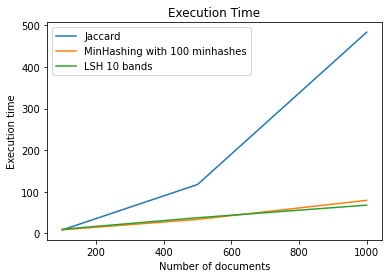

In [39]:
plt.plot(document_size, time_jaccard,  label='Jaccard')
plt.plot(document_size, time_minHashing, label='MinHashing with ' + str(num_minHash)+ " minhashes")
plt.plot(document_size, time_lsh,  label='LSH '+ str(num_bands) +" bands")
plt.title("Execution Time")
plt.xlabel('Number of documents')
plt.ylabel('Execution time')
plt.legend()
plt.show()

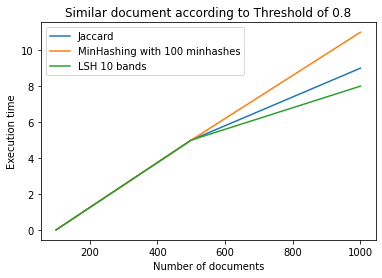

In [40]:
plt.plot(document_size, count_jaccard,  label='Jaccard')
plt.plot(document_size, count_minHashing, label='MinHashing with ' + str(num_minHash)+ " minhashes")
plt.plot(document_size, count_lsh,  label='LSH '+ str(num_bands) +" bands")
plt.title("Similar document according to Threshold of " +str(threshold))
plt.xlabel('Number of documents')
plt.ylabel('Execution time')
plt.legend()
plt.show()

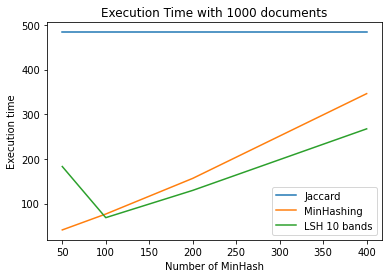

In [41]:
plt.plot(num_minHash_list, [time_jaccard[-1]]*len(num_minHash_list),  label='Jaccard')
plt.plot(num_minHash_list, time_minHashing_num , label='MinHashing')
plt.plot(num_minHash_list, time_lsh_minHashing_num,  label='LSH '+ str(num_bands) +" bands")
plt.title("Execution Time with "+ str(document_size[-1]) +" documents")
plt.xlabel('Number of MinHash')
plt.ylabel('Execution time')
plt.legend()
plt.show()

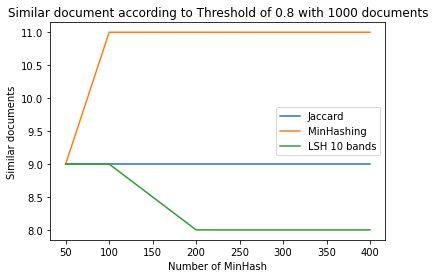

In [42]:
plt.plot(num_minHash_list, [count_jaccard[-1]]*len(num_minHash_list),  label='Jaccard')
plt.plot(num_minHash_list, count_minHashing_num , label='MinHashing')
plt.plot(num_minHash_list, count_lsh_minHashing_num,  label='LSH '+ str(num_bands) +" bands")
plt.title("Similar document according to Threshold of " +str(threshold)+ " with "+ str(document_size[-1]) +" documents")
plt.xlabel('Number of MinHash')
plt.ylabel('Similar documents')
plt.legend()
plt.show()

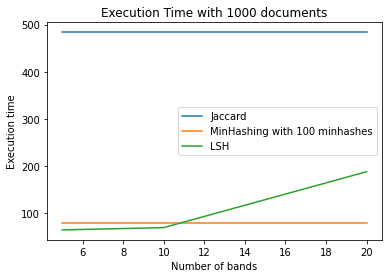

In [43]:
plt.plot(band_size, [time_jaccard[-1]]*len(band_size),  label='Jaccard')
plt.plot(band_size, [time_minHashing[-1]]*len(band_size), label='MinHashing with ' + str(num_minHash)+ " minhashes")
plt.plot(band_size, time_band,  label='LSH')
plt.title("Execution Time with "+ str(document_size[-1]) +" documents")
plt.xlabel('Number of bands')
plt.ylabel('Execution time')
plt.legend()
plt.show()

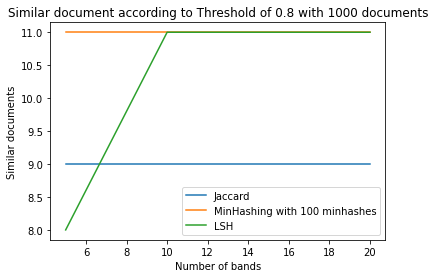

In [44]:
plt.plot(band_size, [count_jaccard[-1]]*len(band_size),  label='Jaccard')
plt.plot(band_size, [count_minHashing[-1]]*len(band_size), label='MinHashing with ' + str(num_minHash)+ " minhashes")
plt.plot(band_size, count_band,  label='LSH')
plt.title("Similar document according to Threshold of " +str(threshold)+ " with "+ str(document_size[-1]) +" documents")
plt.xlabel('Number of bands')
plt.ylabel('Similar documents')
plt.legend()
plt.show()